In [1]:
import numpy as np
import scipy
from scipy import stats, signal, ndimage
from scipy.signal import detrend, resample, medfilt, butter, lfilter, filtfilt
import matplotlib.pyplot as plt
from statsmodels import robust
import glob
import tdt
import pandas as pd
import seaborn as sns
from scipy import ndimage
from statsmodels import robust
from shapely.ops import nearest_points
from shapely import wkt
import math
from shapely.ops import nearest_points
import os
import cv2

In [2]:
#########################
## filtering functions ##
#########################
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

#########################
# deeplabcut functions ##
#########################

def load_dlc(csv_file_path):
    import numpy
    M = np.loadtxt(csv_file_path, delimiter=',', skiprows=3)
    # create nose & TTI vectors
    Nx = M[:, 1]
    Ny = M[:, 2]
    Tx = M[:, 10]
    Ty = M[:, 11]
    # calculate centroids using euclidean distance b/w them
    Cx = (Nx + Tx)/2
    Cy = (Ny + Ty)/2
    return Cx, Cy

def load_fp(fp_file_path):
    import tdt
    data = tdt.read_block(fp_file_path, evtype=['streams', 'epocs'])
    GCAMP = data.streams['GCP1'].data[2,:]
    ISOS = data.streams['GCP2'].data[2,:]
    fs = data.streams['GCP1'].fs
    fram = data.epocs['Fram'].onset
    return GCAMP, ISOS, fram, fs

def load_dlc_nose(csv_file_path):
    M = np.loadtxt(csv_file_path, delimiter=',',skiprows=3)
    Nx = M[:, 1]
    Ny = M[:, 2]
    return Nx, Ny

def calculate_animal_centroids(csv_file_path):
    import numpy
    M = np.loadtxt(csv_file_path, delimiter=',', skiprows=3)
    # create nose & TTI vectors
    Nx = M[:, 1]
    Ny = M[:, 2]
    Tx = M[:, 13]
    Ty = M[:, 14]
    Rx = (Nx + Tx)/2
    Ry = (Ny + Ty)/2

    # intruder nose: 19 and 20, intruder TTI: 28 and 29
    WNx = M[:, 19]
    WNy = M[:, 20]
    WTx = M[:, 28]
    WTy = M[:, 29]
    Ix = (WNx + WTx)/2
    Iy = (WNy + WTy)/2
    
    return Rx, Ry, Ix, Iy

def calculate_intruder_distance(Rx, Ry, Ix, Iy):
    # calculate euclidean distance between centroids
    import math
    Distance = []
    for i in range(len(Rx)):
        dist = math.sqrt(((Rx[i].astype(int) - Ix[i])**2)+((Ry[i].astype(int)-Ry[i])**2))
        Distance.append(dist)
        
    return Distance

def downsample_FP(signal, fram, fs, Cx, offset=1, cam_fr=40):
    """
    Inputs:
    -------
    signal: GCAMP (or isosbestic) array of signal values from the TDT system
    fram: array of camera onset times accoording to TDT
    fs: sampling frequency of data
    cam_fr: camera frame rate. in our case values are the same for all cage day trials, but they may not always be!
    Cx: required for downsampling based on positional tracking using dlc
    
    Returns:
    --------
    signal_ds: downsampled signal based on dx
    """
    import math
    sr_diff = fs/cam_fr
    rec_onset = fram[0]
    rec_offset = fram[-1]
    
    # Turn the GCAMP frames into seconds 
    signal_times = np.arange(0, (len(signal)/fs), (1/fs))
   
    # Calculate the index within the GCAMP stream that the camera turns on 
    cam_on_idx = (np.where(signal_times==(find_nearest(signal_times,rec_onset))))
    
    # Calculate the time in sec within the GCAMP stream that the camera turns on
    cam_on_sec = signal_times[cam_on_idx]
    
    # Calculate the index within the GCAMP stream that the camera turns off 
    cam_off_idx = (np.where(signal_times==(find_nearest(signal_times, rec_offset))))
    
    # Calculate the time in sec within the GCAMP stream that the camera turns off
    cam_off_sec = signal_times[cam_off_idx]
    
    # crop GCAMP signal from camera on to camera off
    signal_cropped = signal[cam_on_idx[0][0]:cam_off_idx[0][0]]
    
    # Create time array based on number of samples and sample frequency
    # crop time signal from camera on to camera off
    npts = len(signal)
    time_x = np.linspace(1, npts, npts) / fs
    
    # do the same for the time vector
    signal_cropped_time = len(signal_cropped)/fs
    time_cropped = time_x[cam_on_idx[0][0]:cam_off_idx[0][0]]
    
    # Downsample the cropped GCAMP recording to align with the camera frames so can match up with 
    # the Cx and Cy vectors
    signal_ds = []
    for idx, frame in enumerate(Cx):
        signal_ds.append(signal_cropped[int(np.round((idx*np.floor(sr_diff-offset))))])
    
    time_ds = []
    for idx, frame in enumerate(Cx):
        time_ds.append(time_cropped[int(np.round((idx*np.floor(sr_diff-offset))))])    
    
    return signal_ds, time_ds

def find_nearest(array,value):
    '''
    Finds the closest value in a given sorted array to your input value. 
    Only works on an increasing sorted array!
    '''
    import math
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]
    
def calculate_cage_distance(csv_file_path, Cx, Cy):
    # import necessary packages
    import math
    # calculate distance from top corner
    TCx = np.mean(Cx)
    TCy = np.max(Cy)
    TCDistance = []
    for i in range(len(Cx)):
        dist = math.sqrt(((Cx[i].astype(int) - TCx)**2)+((Cy[i].astype(int)-TCy)**2))
        TCDistance.append(dist)
    # calculate distance from left cornerr
    LCx = np.min(Cx)
    LCy = 200
    LCDistance = []
    for i in range(len(Cx)):
        dist = math.sqrt(((Cx[i].astype(int) - LCx)**2)+((Cy[i].astype(int)-LCy)**2))
        LCDistance.append(dist)   
    # calculate distance from right corner    
    RCx = np.max(Cx)
    RCy = 200
    RCDistance = []
    for i in range(len(Cx)):
        dist = math.sqrt(((Cx[i].astype(int) - RCx)**2)+((Cy[i].astype(int)-RCy)**2))
        RCDistance.append(dist) 
    return TCDistance, LCDistance, RCDistance

def filter_signal(signal_ds, fs):
    import scipy
#     signal = scipy.signal.detrend(signal_ds)
#     sig1 = butter_lowpass_filter(signal,80,fs,order=3)
#     sig2 = butter_highpass_filter(sig1,0.01,fs,order=3)
    sig = scipy.signal.detrend(scipy.stats.zscore(signal_ds))
    return sig

def updated_filter(signal_ds):
    # input: downsampled signal! don't try this on ur raw data!
    signal = scipy.signal.detrend(signal_ds)
    sig1 = scipy.stats.zscore(signal)
    sig2 = scipy.signal.detrend(scipy.signal.savgol_filter(sig1, 15, 3))
    return sig2

def downsampled_peaks(signal_ds, height):
    import scipy
    peaks, _ = scipy.signal.find_peaks(signal_ds, height=height, threshold=0.001)
    return peaks

def new_fp_peaks(raw_signal,fs):
    sig = detrend(raw_signal)
    sig2 = butter_highpass_filter(sig,0.1,fs,order=3)
    sig3 = butter_lowpass_filter(sig2,30,fs,order=3)
    return sig3

import math  
def calculateDistance(x1,y1,x2,y2):  
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
    return dist 

In [8]:
################################################
################ load data #####################
################################################

# load time data
times = (pd.read_excel('/jukebox/falkner/Dakota/PMV_AM/analysis/cageday/pmv_solorecordings.xlsx'))
# define mouse
animid = '749'
sex = 'M'

x = times.loc[13,['bc','c57f','c57m','swf','swm','clean','empty']]
# x = times.loc[0,['bc','c57f','c57m','swf','swm']] #741 only
solotimes_in = []
for i in range(len(x)):
    solotimes_in.append(x[i])
solotimes_in.append(95)
solotimes_in

# define file paths

csv_path = '/jukebox/falkner/Dakota/PMV_AM/*dat'+sex+animid+'_cageday*/*cage_b*.csv'
fp_path = '/jukebox/falkner/Dakota/PMV_AM/*dat'+sex+animid+'_cageday*/*cage'
csv_path
# load csv data
files = sorted(glob.glob(csv_path))
pos = [load_dlc(f) for f in files]

# load fp data
fp_dat = sorted(glob.glob(fp_path))
fp = [load_fp(f) for f in fp_dat]


################################################
############## extract & ds ####################
################################################

# initialize vectors
Cx = []
Cy = []
GCAMP = []
isos = []
fram = []
fs = []
sig=[]
time=[]
offset=1

# iterate through arrays of loaded data
# separate out position & fp signals 
# then create arrays of important variables (Cx, GCAMP....)
for i in range(len(fp_dat)):
    Cx.append(pos[i][0])
    Cy.append(pos[i][1])
    GCAMP.append(fp[i][0])
    isos.append(fp[i][1])
    fram.append(fp[i][2])
    fs.append(fp[i][3])
    
    ds = downsample_FP(GCAMP[i], fram[i], fs[i], Cx[i], offset=offset,cam_fr=40)
    sig.append(ds[0])
    time.append(ds[1])
    
################################################
################# filter #######################
################################################

sigfilt = []
for i in range(len(fp_dat)):
    f = updated_filter(sig[i])
    sigfilt.append(f)

read from t=0s to t=445.95s
read from t=0s to t=431.11s
read from t=0s to t=425.1s
read from t=0s to t=417.52s
read from t=0s to t=427.0s
read from t=0s to t=447.55s
read from t=0s to t=1040.37s
read from t=0s to t=334.81s


In [9]:
times

,ID,sex,animid,rank,bc,swm,c57m,swf,c57f,clean,...,home,c57f_in,Unnamed: 13,clean_in,Unnamed: 15,empty_in,bc_in,swm_in,c57m_in,swf_in
0,741,M,M1,high,112,100,105,105,99,112,...,10,01:39:00,NaN,video missing,NaN,video missing,01:52:00,01:40:00,01:45:00,01:45:00
1,742,M,badsig,badsig,117,92,99,98,130,109,...,10,02:10:00,NaN,01:49:00,NaN,01:39:00,01:57:00,01:32:00,01:39:00,01:38:00
2,745,M,M2,high,95,105,105,96,114,99,...,10,01:54:00,NaN,01:39:00,NaN,01:39:00,01:35:00,01:45:00,01:45:00,01:36:00
3,744,M,M3,low,111,96,107,121,111,97,...,10,cage never switches?,NaN,01:37:00,NaN,01:26:00,01:51:00,01:36:00,01:47:00,02:01:00
4,746,M,M4,low,112,157,136,100,85,90,...,10,01:25:00,NaN,01:30:00,NaN,01:38:00,01:54:00,02:37:00,02:16:00,01:40:00
5,747,M,badsig,badsig,84,94,93,110,152,100,...,10,02:32:00,NaN,01:40:00,NaN,01:49:00,01:24:00,01:34:00,01:33:00,01:50:00
6,749,M,M5,high,99,103,96,117,83,102,...,10,01:23:00,NaN,01:42:00,NaN,01:29:00,01:39:00,01:43:00,01:36:00,01:57:00
7,755,F,badsig,badsig,87,90,87,104,100,85,...,10,01:40:00,NaN,01:25:00,NaN,01:28:00,01:27:00,01:30:00,01:27:00,01:44:00
8,736,F,F1,high,100,90,92,90,95,98,...,10,01:35:00,NaN,01:38:00,NaN,01:30:00,01:40:00,01:30:00,01:32:00,01:30:00
9,737,F,F2,low,87,92,83,82,85,83,...,10,01:25:00,NaN,01:23:00,NaN,01:35:00,01:27:00,01:32:00,01:23:00,01:22:00


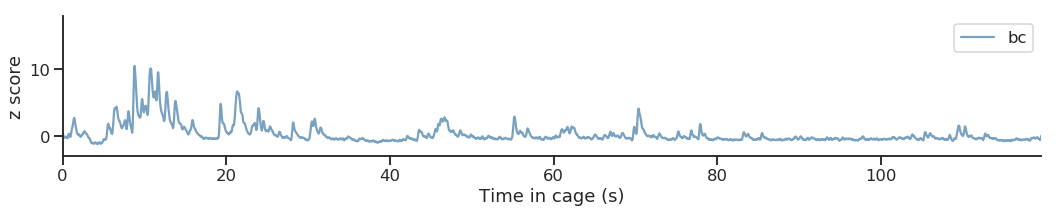

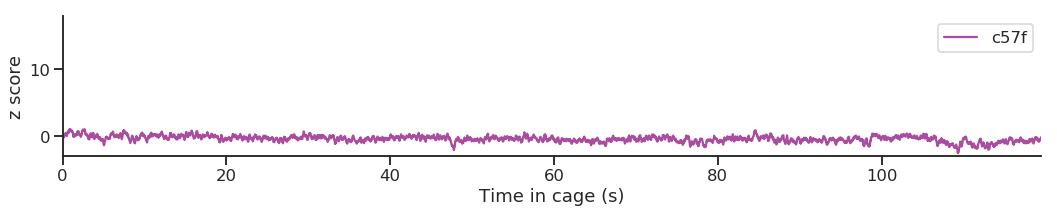

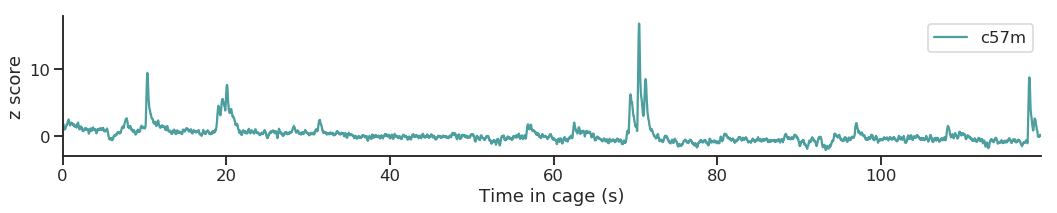

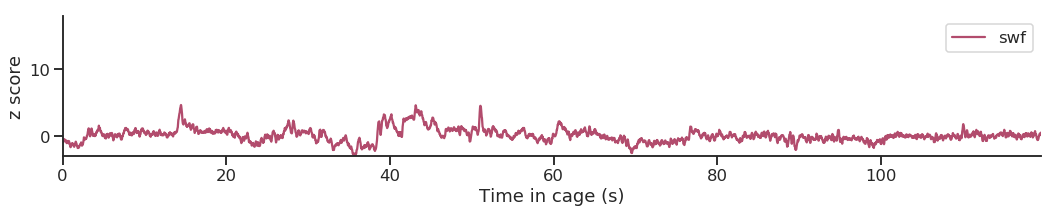

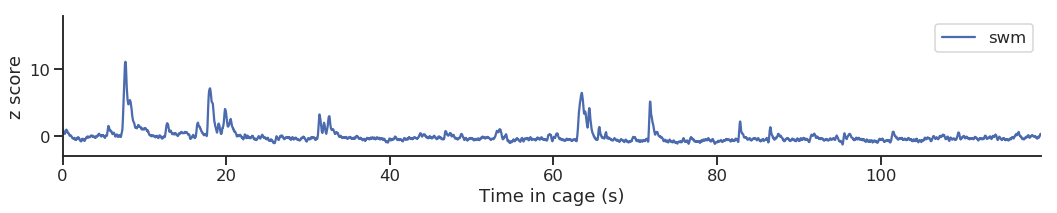

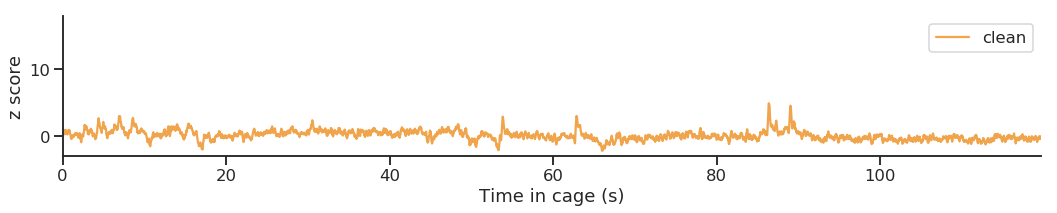

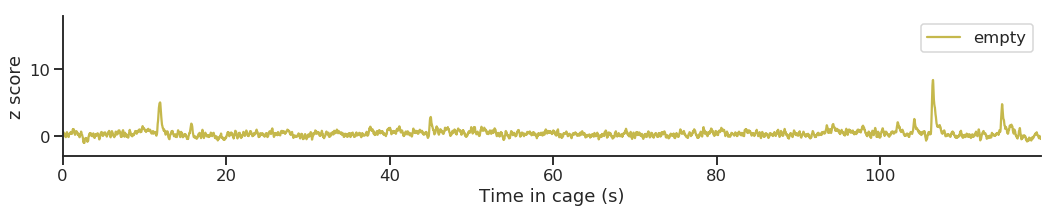

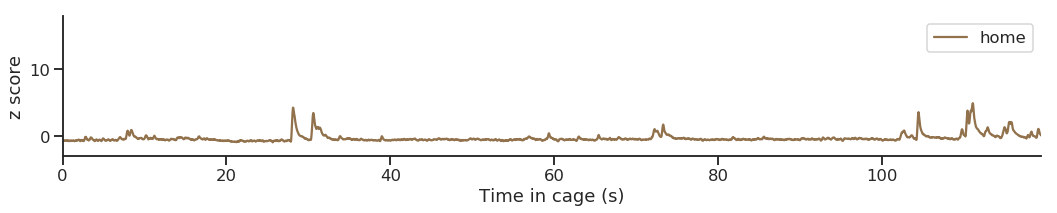

In [15]:

    
################################################
################## crop ########################
################################################

contexts = ['bc','c57f','c57m','swf','swm','clean','empty','home']
times_in = np.array(solotimes_in)
times_out = np.array(times_in + 120)
start = []
end = []
for i in range(len(times_in)):
    start.append(np.floor(len(time[i])/time[i][-1]*times_in[i]).astype(int))
    end.append(np.floor(len(time[i])/time[i][-1]*times_out[i]).astype(int))
    
    
################################################
################## plot ########################
################################################

colors = ['#417AA6','#860076','#007775','#92002F','#002D8C','#EB7E00','#AD9B00','#633700']
# colors = ['#417AA6','#860076','#007775','#92002F','#002D8C','#633700'] #741 only

for i in range(len(fp_dat)):
    s = start[i]
    e = end[i]
    
    datapoints = len(sigfilt[i][s:e])
    pks = downsampled_peaks(sigfilt[i][s:e], height=1)
    seconds = time[i][e] - time[i][s]
    relativetime = np.linspace(0,seconds,datapoints)
    
    sns.set_context('talk')
    sns.set_style('ticks')
    
    
    if rank == 'high':
        alpha=1
    
    else:
        alpha=0.7
    
    fig, ax = plt.subplots()
    fig.set_size_inches(15,3)
    
    plt.tight_layout()
    plt.margins(x=0)
    
    plt.ylim(-3,18)

    ax = sns.lineplot(x=relativetime,y=sigfilt[i][s:e],color=colors[i],alpha=alpha, label=contexts[i])
    ax.legend()
    sns.despine()
    plt.xlabel('Time in cage (s)')
    plt.ylabel('z score')

## code from yuhang

Text(0.5,1,'Occupancy (counts) on each bin')

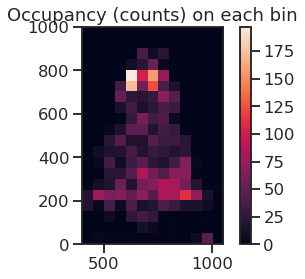

In [89]:
x = Cx[0][start[0]:end[0]]
y = Cy[0][start[0]:end[0]]
gcamp = sigfilt[0][start[0]:end[0]]

binwidth = 50
xlim = [400, 1050]
ylim = [0, 1000]
x_edges = np.arange(xlim[0], xlim[-1] + binwidth, binwidth) 
y_edges = np.arange(ylim[0], ylim[-1] + binwidth, binwidth) 
corners = (xlim[0] - binwidth, xlim[1] + binwidth, ylim[0]- binwidth, ylim[1] + binwidth)
r_count = binned_statistic_2d(x, y, None, 'count', bins=[x_edges, y_edges])
 # occupancy plot
plt.imshow(r_count.statistic.T, origin='lower', extent=(*xlim, *ylim))
plt.colorbar()
plt.title('Occupancy (counts) on each bin')

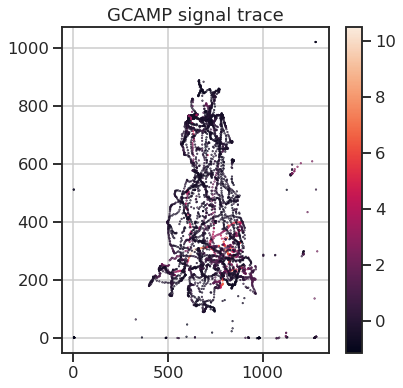

In [90]:
plt.figure(figsize=(6,6))
plt.scatter(x, y, c=gcamp, s=0.4)
plt.grid()
plt.title('GCAMP signal trace')
plt.colorbar()
plt.show()

Text(0.5,1,'Mean GCAMP signal in each bin')

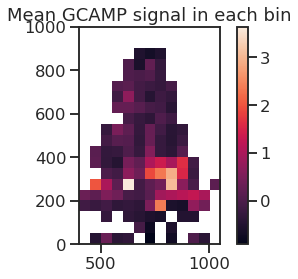

In [91]:
# mean GCAMP signal in each bin
r_mean = binned_statistic_2d(x, y, gcamp, 'mean', bins=[x_edges, y_edges], expand_binnumbers=True)
plt.imshow(r_mean.statistic.T, origin='lower', extent=(*xlim, *ylim))
plt.colorbar()
plt.title('Mean GCAMP signal in each bin')
# there are nans in the statistic

In [92]:
# toy examplel test
x = [300, 400, 1000, 1050, 2000]
y = [-1, 0, 100, 1000, 1100]
r = binned_statistic_2d(x, y, None, 'count', bins=[x_edges, y_edges], expand_binnumbers=True)
r.binnumber

array([[ 0,  1, 13, 13, 14],
       [ 0,  1,  3, 20, 21]])

In [93]:
xx, yy = np.meshgrid(np.arange(xlim[0] - binwidth, xlim[-1] + 2*binwidth, binwidth), 
                    np.arange(ylim[0] - binwidth, ylim[-1] + 2*binwidth, binwidth) )

In [94]:
r = binned_statistic_2d(xx.reshape(-1, 1).squeeze(), yy.reshape(-1, 1).squeeze(), None, 'count', bins=[x_edges, y_edges], expand_binnumbers=False)

In [95]:
# note the X outside xlim is still counted into one binnumber, but not into statistics
# the number of values of binnumber is len(x_edges) + 1
# the shape of r.statistic is (len(x_edges)-1, len(y_edges)-1)
x = Cx[0][start[0]:end[0]]
y = Cy[0][start[0]:end[0]]
gcamp = sigfilt[0][start[0]:end[0]]

binwidth = 50
xlim = [400, 1050]
ylim = [0, 1000]
x_edges = np.arange(xlim[0], xlim[-1] + binwidth, binwidth) 
y_edges = np.arange(ylim[0], ylim[-1] + binwidth, binwidth) 
corners = (xlim[0] - binwidth, xlim[1] + binwidth, ylim[0]- binwidth, ylim[1] + binwidth)
r_count = binned_statistic_2d(x, y, None, 'count', bins=[x_edges, y_edges])

In [96]:
r_count = binned_statistic_2d(x, y, None, 'count', bins=[x_edges, y_edges])
n_bins = (len(x_edges) + 1) * (len(y_edges) + 1)
X = int_2_one_hot(r_count.binnumber, dim=n_bins)
X = np.hstack([np.ones_like(gcamp).reshape(-1, 1), X]) # add a column of ones

In [97]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
gpr = GaussianProcessRegressor(n_restarts_optimizer=9, normalize_y=False)
gpr.fit(X, gcamp)
x_test = np.hstack([np.ones(n_bins).reshape(-1, 1), np.eye(n_bins)])
y_pred, std_pred = gpr.predict(x_test, return_std=True)
gp_grid_full = y_pred.reshape(len(x_edges) + 1 , len(y_edges) + 1)
gp_grid = np.delete(gp_grid_full, (0, -1), axis=0) # the first and last column are outside of range
gp_grid = np.delete(gp_grid, (0, -1), axis=1) # the first and last row are outside of range
print(gp_grid.shape)

(14, 21)


/usr/people/dakotab/anaconda3/envs/db-conda/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/people/dakotab/anaconda3/envs/db-conda/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  
/usr/people/dakotab/anaconda3/envs/db-conda/lib/python3.5/site-packages/ipykernel_launcher.py:9: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  if __name__ == '__main__':


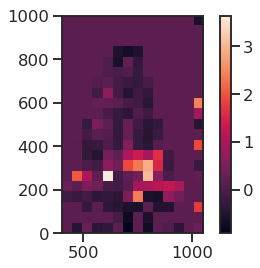

In [98]:
plt.imshow(gp_grid.T, origin='lower', extent=(*xlim, *ylim))
plt.colorbar()
# plt.title(‘GP Regression’)
# plt.savefig(‘GPR_fit.png’)
plt.show()

In [99]:
from sklearn.metrics import r2_score
# model y = X @ w, where X contains constant column
w, res, rank, s = np.linalg.lstsq(X, gcamp)
r2_score(gcamp, X @ w)

/usr/people/dakotab/anaconda3/envs/db-conda/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


0.2940416944107941

In [100]:
from sklearn.linear_model import Ridge
l2_model = Ridge(alpha=0.7)
l2_model.fit(X, gcamp)
w_l2 = l2_model.coef_ # that's the w matrix

(15, 22)


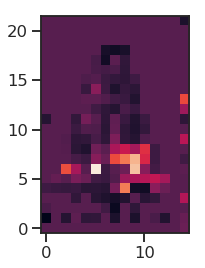

(14, 21)


/usr/people/dakotab/anaconda3/envs/db-conda/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  import sys
/usr/people/dakotab/anaconda3/envs/db-conda/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  


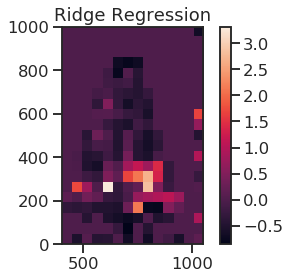

In [101]:
ls_w = w_l2[1:] + w_l2[0]
w_l2_grid_full = ls_w.reshape(len(x_edges) + 1, len(y_edges) + 1)
print(w_l2_grid_full.shape)
plt.imshow(w_l2_grid_full.T, origin='lower')
plt.show()

w_l2_grid = np.delete(w_l2_grid_full, (0, -1), axis=0) # the first and last column are outside of range
w_l2_grid = np.delete(w_l2_grid, (0, -1), axis=1) # the first and last row are outside of range
print(w_l2_grid.shape)

plt.imshow(w_l2_grid.T, origin='lower', extent=(*xlim, *ylim))
plt.colorbar()
plt.title('Ridge Regression')
plt.show()

In [102]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
gpr = GaussianProcessRegressor()
gpr.fit(X, gcamp)
y_pred, std_pred = gpr.predict(x_test, return_std=True)
gp_grid_full = y_pred.reshape(len(x_edges) + 1 , len(y_edges) + 1)
gp_grid = np.delete(gp_grid_full, (0, -1), axis=0) # the first and last column are outside of range
gp_grid = np.delete(gp_grid, (0, -1), axis=1) # the first and last row are outside of range
print(gp_grid.shape)
plt.imshow(gp_grid.T, origin='lower', extent=(*xlim, *ylim))
plt.colorbar()

/usr/people/dakotab/anaconda3/envs/db-conda/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


KeyboardInterrupt: 

In [107]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
# >>> X, y = make_friedman2(n_samples=500, noise=0, random_state=0)
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=9,random_state=0)
gpr.fit(X, gcamp)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=9, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=0)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=0)